# Employee Attrition Prediction

---

A stable workforce is vital for organisation's success, leading to increased productivity, cost effectiveness and retention of institutional knowledge. This project aims to predict employee attrition using Random Survival Forest (RSF) model, identify factors that influences attrition, and propose intervention strategies.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis.

---

## Performing Data Wrangling

After importing the dataset, we first skim the data and check for data types, ranges, duplicates and empty values.

In [1]:
# Importing data
rm(list = ls())
hr <- read.csv("hr_data.csv")

# First few rows.
head(hr)
# Number of duplicated rows
nrow(hr[duplicated(hr), ])
# Number of empty values
sum(is.na(hr))
# All column's range and type
summary(hr)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


[1] 0

[1] 0

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1470        Length:1470        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 465.0  
 Median :36.00   Mode  :character   Mode  :character   Median : 802.0  
 Mean   :36.92                                         Mean   : 802.5  
 3rd Qu.:43.00                                         3rd Qu.:1157.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1470        Min.   : 1.000   Min.   :1.000   Length:1470       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.193   Mean   :2.913                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

There are issues that we can solve by transforming our data:

1. Some unnecessary variables for analysis, such as the one reflecting unique identification (that is, `EmployeeNumber`) and the single-valued ones (such as `EmployeeCount`).

2. All string variables are categorical, with some variables specifically binary.

We will filter `EmployeeNumber` and single-valued variables via column name list to retain original dataset, and adjust the format of categorical variables. For the purpose of clarifying survival status in R's package, we convert variable `Attrition` into Boolean type.

A separate exploration conducted by Project Creator indicates possible cross-column consistency issues, particularly from time period columns (`Age`, `TotalWorkingYears`, `Years...`) and income columns (`DailyRate`, `HourlyRate`, `MonthlyIncome`, `MonthlyRate`). These may have been accidentally introduced during the creation process of our synthetic data, and with the lack of complete data column descriptions, we are skipping cleaning this aspect for now. We are also making a mental note that time period columns may have a zero value, perhaps from a round-down of "six months or less".

## Performing Additional Cleaning

In [2]:
# Filter columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) length(unique(col)) == 1)]
cols <- cols[!(cols %in% single_value_cols)]

# Convert column data types
cat_cols <- c("BusinessTravel", "Department", "EducationField", "JobRole")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Gender", "MaritalStatus", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) ifelse(col == "Yes", TRUE, FALSE))

head(hr[cols])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<lgl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,FALSE,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,FALSE,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,FALSE,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,FALSE,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,FALSE,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,FALSE,⋯,3,3,0,8,2,2,7,7,3,6


---

## Developing Initial Random Survival Forest Model

We develop Random Survival Forest model, available from R's library `randomForestSRC`. Random Survival Forest allows us to examine non-linear relationships in survival data.

Initially we will use all our variables as the features, sparing `YearsAtCompanies` as the survival time variable and `Attrition` as status variable. The number of trees used is on the lower scale (100) for faster process. To measure model's accuracy, we use Prediction Error Curve (PEC) which is an integrated Brier score over time.

We then determine the overall importance score of features to understand what contributes to an employee's attrition, and also to select features for updating our model.

[1] "Average variable importance:"
    YearsWithCurrManager                 OverTime       YearsInCurrentRole 
            5.744014e-02             5.455311e-02             4.085335e-02 
       TotalWorkingYears                      Age                 JobLevel 
            2.737789e-02             2.637951e-02             2.454648e-02 
      NumCompaniesWorked            MonthlyIncome         StockOptionLevel 
            2.025847e-02             1.888807e-02             1.583246e-02 
                 JobRole  EnvironmentSatisfaction          JobSatisfaction 
            7.600553e-03             7.502880e-03             5.898857e-03 
         WorkLifeBalance         DistanceFromHome           JobInvolvement 
            5.731849e-03             5.654502e-03             2.749258e-03 
   TrainingTimesLastYear  YearsSinceLastPromotion               Department 
            2.691009e-03             2.291301e-03             2.207732e-03 
       PercentSalaryHike RelationshipSatisfaction    

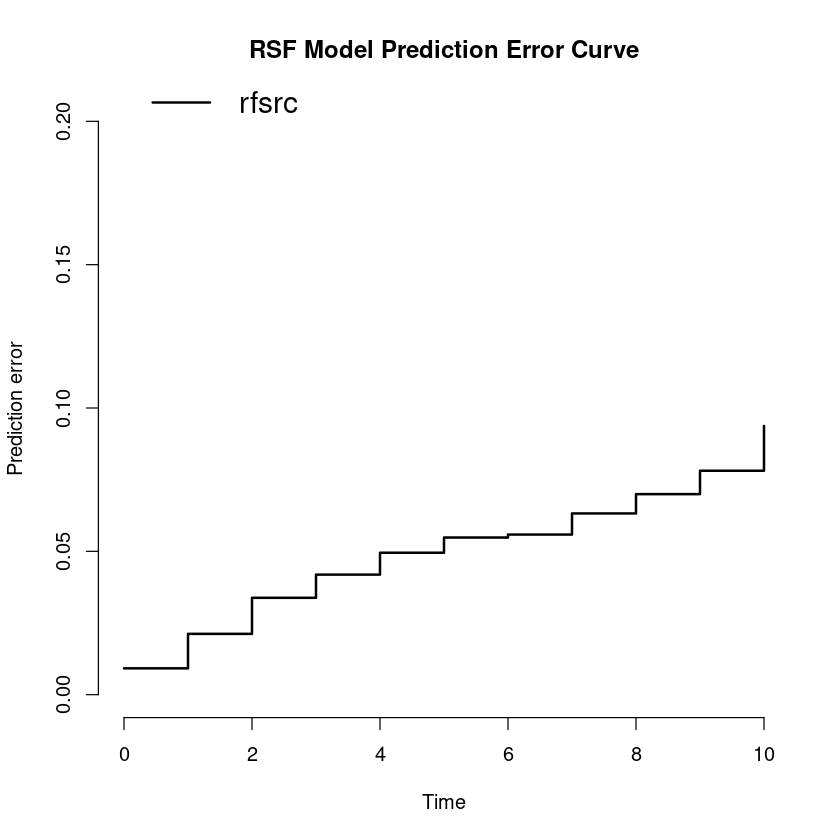

In [3]:
suppressMessages(library(randomForestSRC))
library(survival)
suppressMessages(library(pec))
library(ggplot2)
suppressMessages(library(viridis))

# Base model
rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100)
  return(model)
}

# Accuracy plot
plot_pec <- function(df, model) {
  suppressMessages(pred_error <- pec(model, data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "cv10", cens.model = "marginal", reference = FALSE))
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.2))
  title("RSF Model Prediction Error Curve")
}

# Importance function
rsf_importance <- function (df, model, sort = TRUE) {
  importance <- predict(model, df, importance = TRUE)$importance
  if (sort) {
      importance <- importance[order(importance, decreasing = TRUE)]
  }
  return(importance)
}

# Cross-validation functions
train_test_generate <- function (df, proportion = 0.7) {
  size <- round(proportion * nrow(df))
  idx <- sample(seq_len(nrow(df)), size = size, replace = FALSE)
  return(list("train" = df[idx, ], "test" = df[-idx, ]))
}
k_fold_cross_val <- function (df, k = 20) {
  for (fold in 1:k) {
    separate <- train_test_generate(df)
    train <- separate$train
    test <- separate$test
    model <- rsf_model(train)
    if (!(exists("importance_tot"))) {
      importance_tot <- rsf_importance(test, model, FALSE)
    } else {
      importance_tot <- importance_tot + rsf_importance(test, model, FALSE)
    }
  }
  print("Average variable importance:")
  print(importance_tot[order(importance_tot, decreasing = TRUE)]/length(importance_tot))
}

# First iteration
hr1 <- hr[cols]
model_v1 <- rsf_model(hr1)
plot_pec(hr1, model_v1)
k_fold_cross_val(hr1)

The PEC graph shows that our model has at least $92\%$ accuracy ($8\%$ error) in predicting employee retention/attrition probability within the span of 10 years. This might indicate data overfitting, so we will refine our model mostly by simplifying features.

## Refining Our Model with Feature Selection

From the importance table, time-dependent variables such as `YearsWithCurrManager`, `YearsInCurrentRole`, `TotalWorkingYears` and `Age`, dominate the model. This might indicate that they are highly correlated with our survival-time variable `YearsAtCompany`, thus encoding redundant information for survival analysis and needing to be removed from the model.

Meanwhile, work-welfare-related variables such as `Overtime`, `StockOptionLevel` and `MonthlyIncome` may provide insights to tackle employee attrition. Career-oriented features such as `JobLevel` and `NumCompaniesWorked` also appear important.

By generating correlation heatmap on the features we just discussed (`Age`, `TotalWorkingYears`, ..., `NumCompaniesWorked`) as well as target variables (`Attrition` and `YearsAtCompany`), we can see that:

1. The time-varying covariates are indeed highly correlated ($> 0.7$) with each other. We remove these from our next model features, except `Age` which does not suffer much from multicollinearity and is a common demographic information.

2. `JobLevel` and `MonthlyIncome` are also highly linked, which allow us to remove either one to simplify our model. `MonthlyIncome` is retained due to being continuous variable by definition. However, we are currently losing the semantic of company leadership structure. To mitigate that, we will add `JobRole` to our model which is moderately influential from previous result.

    Notice that since correlation map is unavailable for categorical variables, we treated some of categorical variables such as`JobLevel` as continuous.

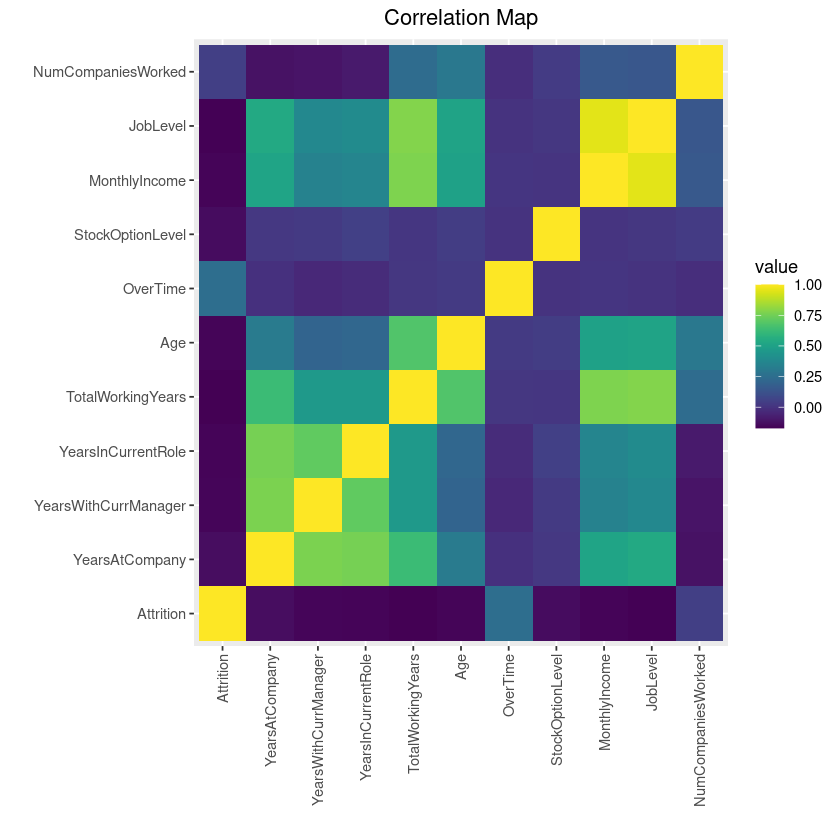

In [4]:
# Correlation
library(reshape2)

plot_correlation <- function (df, model) {
  # Only numerical (unless categories can be continuously extended)
  cor_matrix <- cor(df)
  ggplot(data = melt(cor_matrix), aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() + scale_fill_viridis() +
    xlab("") + ylab("") + ggtitle("Correlation Map") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         plot.title = element_text(hjust = 0.5))
}

focus_cols <- c("Attrition", "YearsAtCompany", "YearsWithCurrManager", "YearsInCurrentRole", "TotalWorkingYears",
                "Age", "OverTime", "StockOptionLevel", "MonthlyIncome", "JobLevel", "NumCompaniesWorked")
plot_correlation(hr[focus_cols], model_v1)

If we redo the plot, we should see more independencies:

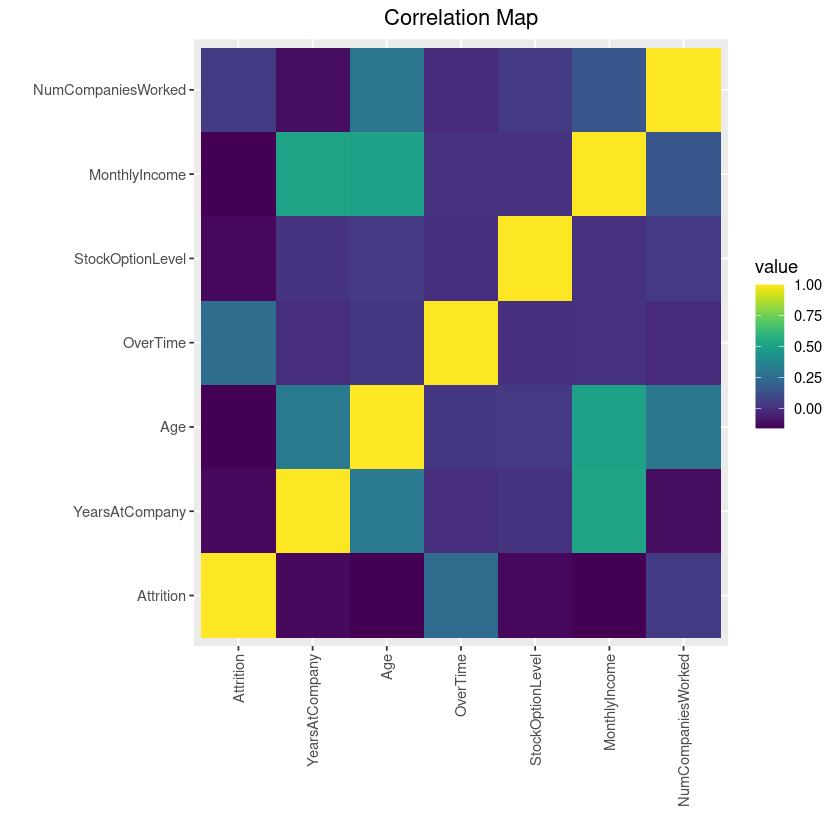

In [5]:
focus_cols <- c("Attrition", "YearsAtCompany", "Age", "OverTime", "StockOptionLevel",
                "MonthlyIncome", "NumCompaniesWorked")
plot_correlation(hr[focus_cols], model_v1)

The variable `NumCompaniesWorked` can confuse the effect of job-hopping and one of longer work experience. However, since it does not seem to correlate much with `TotalWorkingYears`, we can somewhat assume that it is an indicator of job-hopping.

Now, we examine aggregated historical attrition rates based on the categorical features, just to make sure the direction of the trend, i.e. whether it is increasing or decreasing, or a more complicated form.

In [6]:
suppressMessages(library(dplyr))

aggregated_attrition <- function (df, col) {
    options(warn = -1) # Suppress warnings
    
    # Best for categorical (unless numerical int range is small)
    result <- df[, c("Attrition", col)] %>%
      group_by_(col) %>%
      summarize(
        AttritionCount = sum(Attrition),
        TotalEmployees = n(),
        AttritionRate = AttritionCount/TotalEmployees
    )
    
    options(warn = 0) # Reactivate warnings
    return(result)
}

aggregated_attrition(hr, "OverTime")
aggregated_attrition(hr, "StockOptionLevel")
aggregated_attrition(hr, "NumCompaniesWorked")
aggregated_attrition(hr, "JobRole")

OverTime,AttritionCount,TotalEmployees,AttritionRate
<lgl>,<int>,<int>,<dbl>
FALSE,110,1054,0.1043643
TRUE,127,416,0.3052885


StockOptionLevel,AttritionCount,TotalEmployees,AttritionRate
<int>,<int>,<int>,<dbl>
0,154,631,0.24405705
1,56,596,0.09395973
2,12,158,0.07594937
3,15,85,0.17647059


NumCompaniesWorked,AttritionCount,TotalEmployees,AttritionRate
<int>,<int>,<int>,<dbl>
0,23,197,0.1167513
1,98,521,0.1880998
2,16,146,0.1095890
3,16,159,0.1006289
4,17,139,0.1223022
5,16,63,0.2539683
6,16,70,0.2285714
7,17,74,0.2297297
8,6,49,0.1224490


JobRole,AttritionCount,TotalEmployees,AttritionRate
<fct>,<int>,<int>,<dbl>
Healthcare Representative,9,131,0.06870229
Human Resources,12,52,0.23076923
Laboratory Technician,62,259,0.23938224
Manager,5,102,0.04901961
Manufacturing Director,10,145,0.06896552
Research Director,2,80,0.02500000
Research Scientist,47,292,0.16095890
Sales Executive,57,326,0.17484663
Sales Representative,33,83,0.39759036


As expected, overtime increases attrition potential. A higher number of previous companies also induces attrition, and there seems to be a sharp cut-off for `NumCompaniesWorked >= 5`. We will reclassify this category as into `High` and `Low` numbers.

In a slightly unexpected way, no stock options and high stock options are linked to higher attrition. We can group the first and second levels, but it does not feel significant enough to make such move, so we will not transform this feature.

Among job positions, managerial positions and Healthcare Representation have around $5\%$ attrition rate, while general positions sit at about $15-25\%$. [A simple online search](https://www.statista.com/statistics/934377/professional-services-worldwide-employee-attrition-by-region/) shows an average of $10-18\%$ global churn rate in 2022, so this company's number is comparatively a pretty high one. Sales reps roles are particularly prone to attrition (a whopping $40\%$) while also having a small number of employees. This is therefore an employee group that we need to focus on for mitigating their leaving.

We can group `JobRole` into five generalised group: leadership, research area, business, and a single group of healthcare and sales representatives.

## Developing Next Model

We perform previously described plan and redo our model. The PEC error shows our simpler model does not differ significantly in accuracy.

[1] "Average variable importance:"
     MonthlyIncome           OverTime                Age   StockOptionLevel 
         0.7462620          0.4698945          0.3494076          0.1784834 
NumCompaniesWorked            JobRole 
         0.1546414          0.1522969 


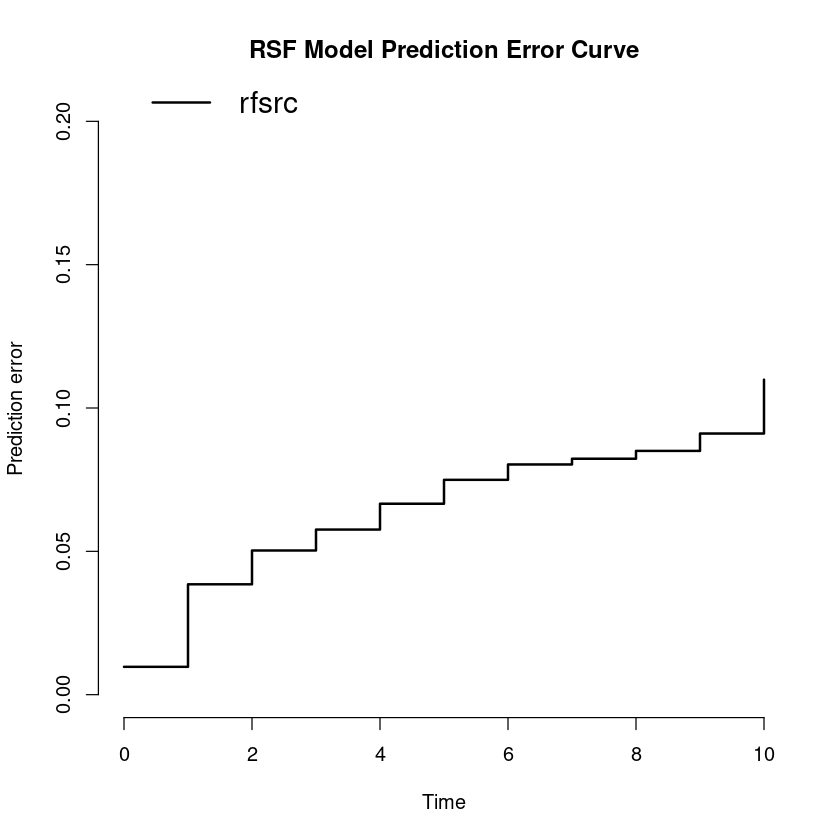

In [16]:
# Regroup categorical features
levels(hr["NumCompaniesWorked"]) <- list("Low" = c(1, 2, 3, 4),
                                         "High" = c(5, 6, 7, 8, 9))
levels(hr["JobRole"]) <- list("Leadership" = c("Manager", "Manufacturing Director", "Research Director"),
                              "Research" = c("Laboratory Technician", "Research Scientist"),
                              "Healthcare Rep" = c("Healthcare Representative"),
                              "Business" = c("Sales Executive", "Human Resources"),
                              "Sales Rep" = c("Sales Representative"))

# Second iteration model
cols <- c("Attrition", "YearsAtCompany", "OverTime", "MonthlyIncome", "Age",
          "StockOptionLevel", "NumCompaniesWorked", "JobRole")
hr2 <- hr[cols]
k_fold_cross_val(hr2)
model_v2 <- rsf_model(hr2)
plot_pec(hr2, model_v2)

---

## Predicting Employee Attrition Result

We create the prediction of attrition probability of our employees in the next five years, adding details such as 40-th quantile and mean. We also identify 50 individuals at risk of leaving their jobs, ignoring the ones with positive attrition already.

In [ ]:
# Predictive result
rsf_attrition_probability <- function (df, model) {
  return(1 - predict(model, df)$survival)
}
pred_attr_probs <- rsf_attrition_probability(hr, model_v2)

# Rough estimate of median and mean quitting time interval
hr["Quantile40AttritionTime"] <- apply(pred_attr_probs, 1, function (F) {
  q = 0.4
  n <- sum(F <= q)
  if (n == 0) { n }
  else if (n == length(F) || F[n] == F[n+1]) { n-1 }
  else{ n-1 + (q - F[n])/(F[n+1] - F[n]) }
})
hr["ExpectedAttritionTime"] <- apply(pred_attr_probs, 1, function (F) {
  lim <- length(F) - 1
  F_smooth <- splinefun(x = 0:lim, y = F, method = "fmm")
  lim - integrate(F_smooth, 0, lim)$value
})

# Appending the prediction for the next five years
years = 5
ap_cols <- sapply(0:years, function(i) paste0("AttritionProbYear", i))
hr[ap_cols] <- pred_attr_probs[, (0:years) + 1]

# Final tabular visualisation
hr["EmployeeNumber"]
while (TRUE) {
  employee_number <- readline("Enter Employee Number (or 'q' to quit): ")
  if (employee_number == "q") break
  employee_number <- as.integer(employee_number)
  if (!(employee_number %in% hr["EmployeeNumber"])) {
    print("Invalid employee number. Please try again.")
    next
  }
  preview_cols <- c("EmployeeNumber", cols, ap_cols, "Quantile40AttritionTime", "ExpectedAttritionTime")
  print(hr[hr$EmployeeNumber == employee_number, preview_cols])
}

,EmployeeNumber,Attrition,YearsAtCompany,OverTime,MonthlyIncome,Age,StockOptionLevel,NumCompaniesWorked,JobRole,AttritionProb_Year0,AttritionProb_Year1,AttritionProb_Year2,AttritionProb_Year3,AttritionProb_Year4,AttritionProb_Year5,Quantile40AttritionTime,ExpectedAttritionTime
,<int>,<lgl>,<int>,<lgl>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1318,1850,FALSE,5,TRUE,2379,27,0,0,Laboratory Technician,0.032358651,0.22427851,0.2789768,0.3850370,0.4675489,0.5661968,3.1813431,7.506686
922,1286,FALSE,4,TRUE,2154,28,0,0,Laboratory Technician,0.030805316,0.21470735,0.2700354,0.3822910,0.4694558,0.5744696,3.2031664,7.529656
319,434,FALSE,4,TRUE,2478,27,0,1,Research Scientist,0.026881387,0.18296575,0.2366558,0.3298082,0.4064399,0.5191899,3.9159634,7.061663
1437,2021,FALSE,2,TRUE,2380,21,0,1,Sales Representative,0.090424510,0.38379766,0.4729150,0.6547792,0.6828201,0.7518065,1.1818090,5.869019
926,1292,FALSE,1,TRUE,2372,42,0,6,Research Scientist,0.042219392,0.15772771,0.2552576,0.3481954,0.4321167,0.5596894,3.6172995,7.149389
816,1131,FALSE,2,TRUE,2070,21,0,1,Research Scientist,0.104929565,0.39578043,0.4775925,0.6446859,0.6757197,0.7305434,1.0515764,6.089564
1436,2020,FALSE,4,TRUE,2436,44,0,6,Research Scientist,0.035983397,0.15352138,0.2432802,0.3306900,0.4105172,0.5433115,3.8682499,7.275909
633,875,FALSE,2,TRUE,2515,42,0,5,Research Scientist,0.029342355,0.13267592,0.2146276,0.2969545,0.3680831,0.4844323,4.2743200,8.226159
1103,1556,FALSE,3,TRUE,2644,36,0,3,Sales Representative,0.025210610,0.15463982,0.2140992,0.3164788,0.4065845,0.4981567,3.9269249,8.058761


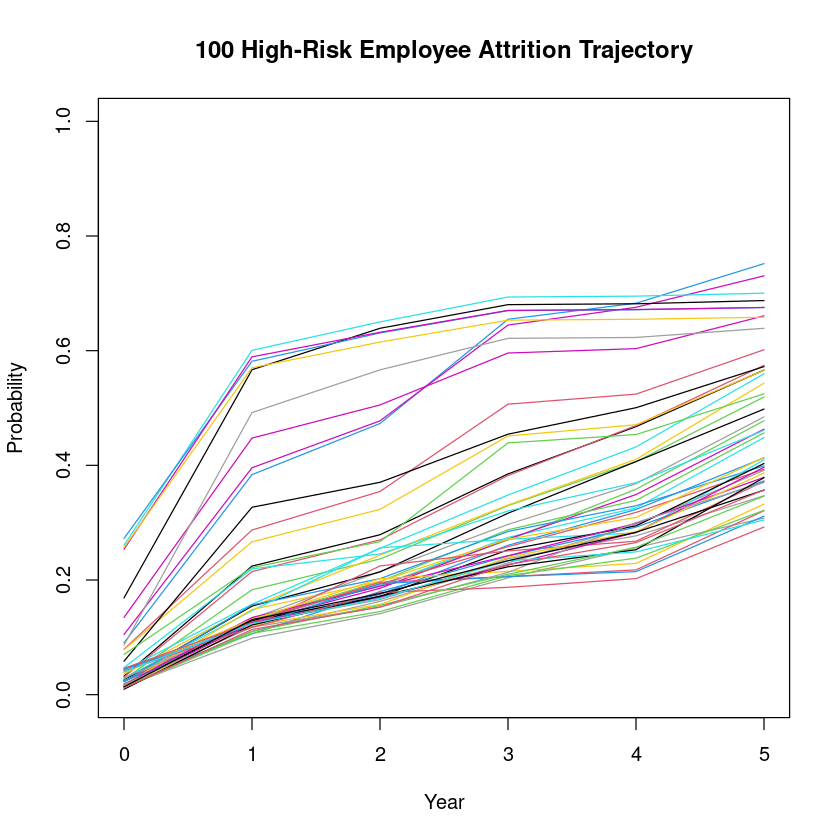

In [98]:
# Top individuals
rsf_high_risk_indiv_idx <- function (df, model, limit = 50) {
  df$HazardScore <- predict(model, df)$predicted
  df <- df[df["Attrition"] == FALSE, ]
  return(row.names(df)[order(df$HazardScore, decreasing = TRUE)[1:limit]])
}

hriidx <- rsf_high_risk_indiv_idx(hr, model_v2)
hr[hriidx, preview_cols]

hrindv <- hr[hriidx, ap_cols]
plot(1, type = "n", xlim = c(0, ncol(hrindv)-1), ylim = c(0, 1), xlab = "Year", ylab = "Probability")
title("100 High-Risk Employee Attrition Trajectory")
for (i in 1:nrow(hrindv)) {
  lines(0:(ncol(hrindv)-1), hrindv[i, ], col = i, type = "l")
}
#legend("topright", legend = hr[hriidx, "EmployeeNumber"], col = 1:nrow(hrindv), lty = 1, title = "EmpID")

## User Interface Visualisation

We will be using Shiny widget here.

In [89]:
employee_number <- as.integer(readline("Enter Employee Number: "))
if (employee_number %in% hr["EmployeeNumber"]) {
    
}

ERROR: Error in parse(text = x, srcfile = src): <text>:2:26: unexpected ')'
1: employee_number <- as.integer(readline("Enter Employee Number: "))
2: if (employee_number %in% )
                            ^


---

## Recommended strategies


### Overtime Management

Excessive overtime can lead to burnout among employees. Implement strategies to manage and reduce overtime, such as workload distribution, hiring additional staff, or arranging flexible work arrangements.

### Salary and Compensation Adjustment

Consider reviewing and maybe adjusting the salary structure to make sure it is competitive within the industry and region. Competitive salary system can help attract and retain talented employees.

### Stock Option Incentives & Communication

Consider expanding the stock option program to make it more attractive to employees. Make sure to communicate clearly to employees how the stock system works and their benefits.

### High Attrition History Analysis

Understand the reasons behind high attrition among employees with a history of working at multiple companies.

### Retention Programs for Sales Reps

Our sales representatives are more prone to attrition. Implement retention programs specific to this group, such as performance-based incentives, career development paths, and mentorship programs.